In [1]:
# import all the tools we need
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import os 
from PIL import Image
import random
import xml.etree.ElementTree as ET
import time
import requests

In [2]:
# path of images directory
dir_path = 'images'

# path of xml files directory
xml_path = 'annotations'

# List of Image file name 
file_list = os.listdir(dir_path)

# How many image files?
print('There are total {} images.'.format(len(file_list)))

There are total 853 images.


In [3]:
# Helper function for read the data (label and bounding boxes) from xml file 
def read_annot(file_name, xml_dir):
    """
    Function used to get the bounding boxes and labels from the xml file
    Input:
        file_name: image file name
        xml_dir: directory of xml file
    Return:
        bbox : list of bounding boxes
        labels: list of labels
    """
    bbox = []
    labels = []
    
    annot_path = os.path.join(xml_dir, file_name[:-3]+'xml')
    tree = ET.parse(annot_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        label = boxes.find('name').text
        bbox.append([xmin,ymin,xmax,ymax])
        if label == 'with_mask':
            label_idx = 2
        else:
            label_idx = 1
        labels.append(label_idx)
        
    return bbox, labels

# help function for drawing bounding boxes on image
def draw_boxes(img, boxes,labels, thickness=1):
    """
    Function to draw bounding boxes
    Input:
        img: array of img (h, w ,c)
        boxes: list of boxes (int)
        labels: list of labels (int)
    
    """
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 2:
            color = (0,225,0) # green
        elif label == 1:
            color = (0,0,225) # red
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


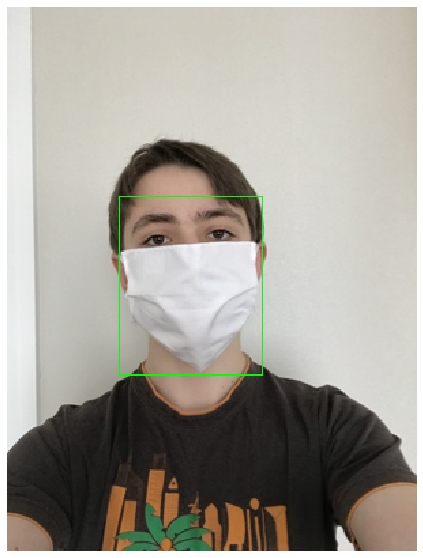

In [4]:
# Get the image randomly
image_name = file_list[random.randint(0,len(file_list))] # random select an image

# Get the bbox and label
bbox, labels  = read_annot(image_name, xml_path)

#draw bounding boxes on the image
img = draw_boxes(plt.imread(os.path.join(dir_path,image_name)), bbox,labels)
    
# display the image
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.axis('off')
ax.imshow(img)

In [5]:
class image_dataset(Dataset):
    def __init__(self, image_list, image_dir, xml_dir):
        self.image_list = image_list
        self.image_dir = image_dir
        self.xml_dir = xml_dir
       
    def __getitem__(self, idx):
        """
        Load the image
        """
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transforms.ToTensor()(img)

        """
        build the target dict
        """
        bbox, labels = read_annot(img_name, self.xml_dir)
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)
        
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img , target
                    
    def __len__(self):
        return len(self.image_list)

In [6]:
mask_dataset = image_dataset(file_list, dir_path, xml_path)

def collate_fn(batch):
    return tuple(zip(*batch))

mask_loader = DataLoader(mask_dataset,
                        batch_size=2,
                        shuffle=True,
                        num_workers=0,
                        collate_fn=collate_fn)

In [7]:
# Setting up GPU device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
# Setting up the model

num_classes = 3 # background, without_mask, with_mask

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

In [9]:
# Setting the optimizer, lr_scheduler, epochs

params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(params, lr=0.01,momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
num_epochs=30

In [10]:
# Main training function
loss_list = []

for epoch in range(num_epochs):
    print('Starting training....{}/{}'.format(epoch+1, num_epochs))
    loss_sub_list = []
    start = time.time()
    for images, targets in mask_loader:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        model.train()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_sub_list.append(loss_value)
        
        # update optimizer and learning rate
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        #lr_scheduler.step()
    end = time.time()
        
    #print the loss of epoch
    epoch_loss = np.mean(loss_sub_list)
    loss_list.append(epoch_loss)
    print('Epoch loss: {:.3f} , time used: ({:.1f}s)'.format(epoch_loss, end-start))

Starting training....1/30
Epoch loss: 0.409 , time used: (265.9s)
Starting training....2/30
Epoch loss: 0.282 , time used: (259.7s)
Starting training....3/30
Epoch loss: 0.237 , time used: (257.1s)
Starting training....4/30
Epoch loss: 0.216 , time used: (253.5s)
Starting training....5/30
Epoch loss: 0.200 , time used: (253.4s)
Starting training....6/30
Epoch loss: 0.181 , time used: (257.5s)
Starting training....7/30
Epoch loss: 0.164 , time used: (256.5s)
Starting training....8/30
Epoch loss: 0.154 , time used: (253.7s)
Starting training....9/30
Epoch loss: 0.140 , time used: (254.1s)
Starting training....10/30
Epoch loss: 0.143 , time used: (253.6s)
Starting training....11/30
Epoch loss: 0.131 , time used: (257.2s)
Starting training....12/30
Epoch loss: 0.122 , time used: (253.4s)
Starting training....13/30
Epoch loss: 0.120 , time used: (253.8s)
Starting training....14/30
Epoch loss: 0.109 , time used: (258.5s)
Starting training....15/30
Epoch loss: 0.130 , time used: (255.6s)
Star

In [11]:
torch.save(model.state_dict(),'./model_0214.pth')

In [12]:
# helper function for single image prediction
def single_img_predict(img, nm_thrs = 0.3, score_thrs=0.8):
    test_img = transforms.ToTensor()(img)
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
        
    test_img = test_img.permute(1,2,0).numpy()
    
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_img, test_boxes, test_labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


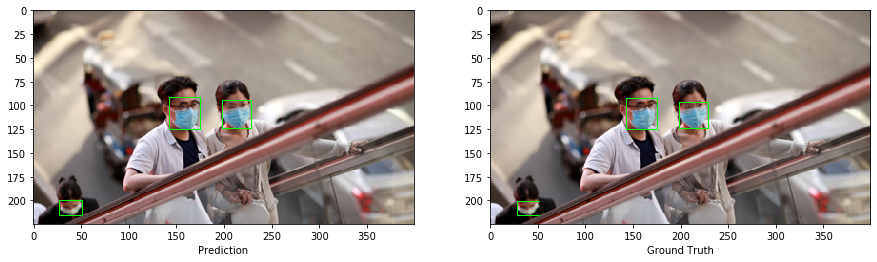

In [13]:
#idx = random.randint(1,len(file_list))
idx = 210
test_img = Image.open(os.path.join(dir_path,file_list[idx])).convert('RGB')

# Prediction
test_img, test_boxes, test_labels = single_img_predict(test_img)
test_output = draw_boxes(test_img, test_boxes,test_labels)

# Draw the bounding box of ground truth
bbox, labels  = read_annot(file_list[idx], xml_path)
#draw bounding boxes on the image
gt_output = draw_boxes(test_img, bbox,labels)

# Display the result
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.imshow(test_output)
ax1.set_xlabel('Prediction')
ax2.imshow(gt_output)
ax2.set_xlabel('Ground Truth')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


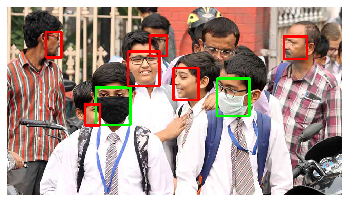

In [17]:
url = 'https://english.cdn.zeenews.com/sites/default/files/2019/11/04/828383-mask.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

test_img, test_boxes, test_labels = single_img_predict(test_img)

# The image size is so large, so we increase the thickness of the bounding box
test_output = draw_boxes(test_img, test_boxes,test_labels, thickness=5)

plt.axis('off')
plt.imshow(test_output)